In [1]:
from tempfile import NamedTemporaryFile
from matplotlib import animation

from matplotlib.collections import LineCollection, CircleCollection


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

Imagine we have a tile of locations, say "cortical columns" that tile the visual field. 

Each column represents a patch of the full visual space. And each patch encodes the visual features with the same set of sparse filters and code words.



In [2]:
from __future__ import division

from pylab import *
import scipy
import time

import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [3]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [4]:
reload(imut)
patch_size=(20,20)
tstart = time.time()
impatches = imut.load_random_imnet_patches(100000, patch_size=patch_size)
print "Duration: ", time.time() - tstart


0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 Duration:  154.922448158


In [5]:
reload(imut)

<module 'imnet_utils' from 'imnet_utils.pyc'>

In [6]:
import glob

im_list = glob.glob('data/image_net/*')
print len(im_list)

12226


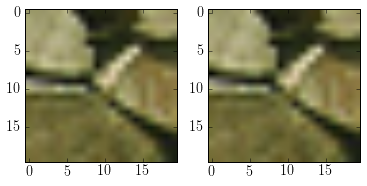

In [7]:
impatchr = impatches.copy().reshape((-1, impatches.shape[3]))

impatchr -= 1
impatchr /= 255



irec = impatchr[:, 22].reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2]))

subplot(121)
imshow((impatches[:,:,:,22]-1)/255)
subplot(122)
imshow(irec)

In [8]:
mean01 = impatchr.mean()
impatchr -= mean01

In [9]:

ncomponents = min(1000, patch_size[0]*patch_size[1]*3-1)

#pca_encoder = TruncatedSVD(ncomponents)
pca_encoder = PCA(ncomponents)
fica_encoder = FastICA(ncomponents)



In [10]:
tstart = time.time()
pca_encoder.fit(impatchr.T)
print 'Duration: ', time.time() - tstart


Duration:  53.6413660049


In [11]:
scores = pca_encoder.transform(impatchr.T)

In [12]:
pc_comp = pca_encoder.components_

print pc_comp.shape

pc_comp_ims = pc_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))

(1000, 1200)


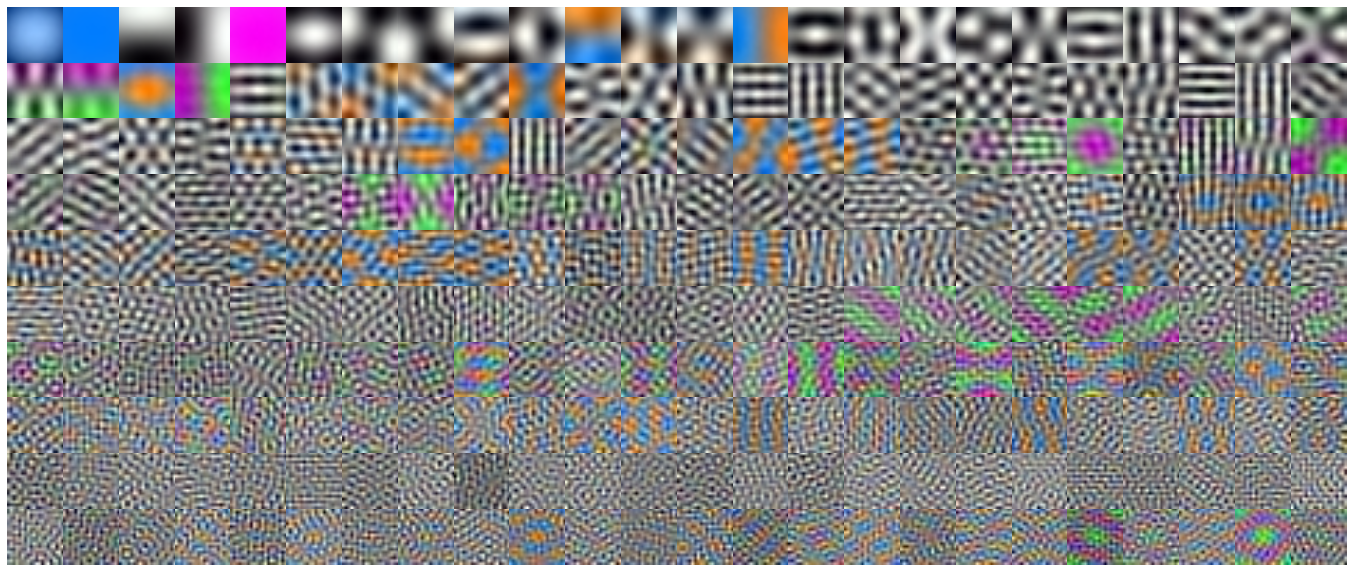

In [13]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = 0

figure(figsize=(24,10))

nshow = 240
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow,maxrow,i+1)
    imshow(norm_range(pc_comp_ims[:,:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [449]:
tstart = time.time()
which_pcs = np.arange(400)
fica_encoder.fit(scores[:,which_pcs])
print 'Duration: ', time.time() - tstart


n_components is too large: it will be set to 400
Duration:  395.115922213


In [450]:
ic_scores = fica_encoder.transform(scores[:1000,which_pcs])

In [451]:
pc_scores = scores[:ic_scores.shape[0], :ic_scores.shape[1]]


In [452]:
ic_comp = fica_encoder.components_
ic_comp /= ic_comp.std(axis=0)
ic_comp = np.dot(ic_comp, pc_comp[which_pcs,:])
print ic_comp.shape

(400, 1200)


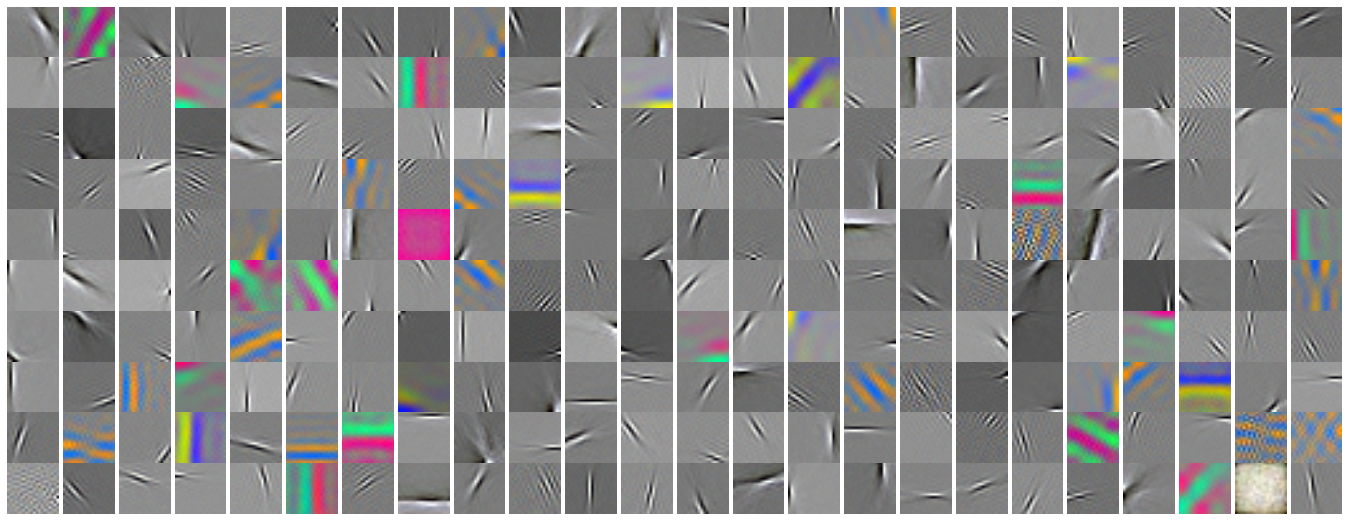

In [453]:
ic_comp_ims = ic_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))
figure(figsize=(24,10))
nshow = min(len(which_pcs), 240)
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    imshow(norm_range(ic_comp_ims[:,:,:,i+0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [454]:
reload(imut)
nrecon = 16
impatch = imut.load_random_imnet_patches(nrecon, patch_size)
#impatch = impatches[:,:,:,58]
impatchr = impatch.reshape((-1, nrecon))
#impatchr -= impatchr.mean(axis=1)[:, np.newaxis]
impatchr -= impatchr.mean()

ic_c = linalg.lstsq(ic_comp.T, impatchr)
pc_c = linalg.lstsq(pc_comp[which_pcs,:].T, impatchr)
ic_code = ic_c[0].T
pc_code = pc_c[0].T

0


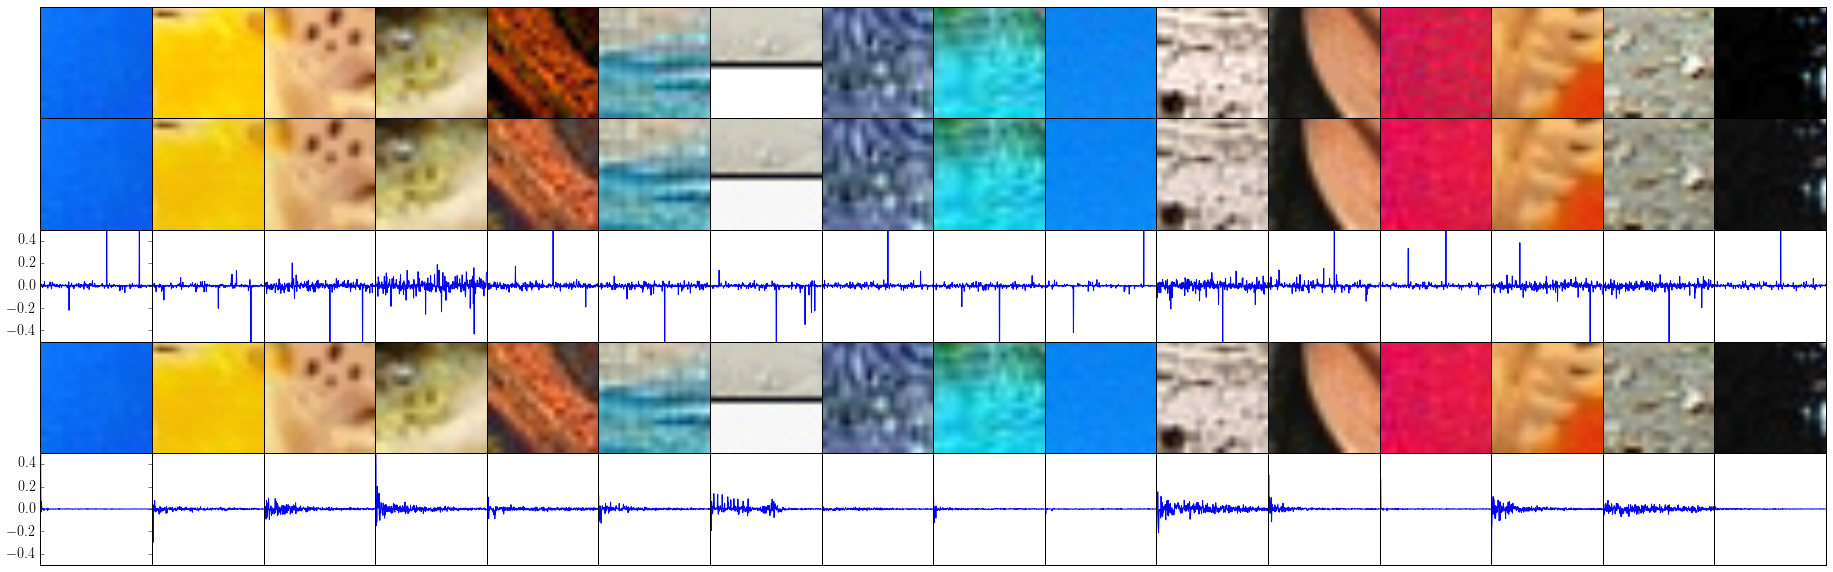

In [455]:


figure(figsize=(32, 10))

for imx in range(nrecon):
    
    ax = subplot(5, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(5, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

    ax = subplot(5, nrecon, imx + 1 + 3*nrecon)
    pc_recon = np.dot(pc_code[imx,:], pc_comp[which_pcs,:])
    pc_reconr = pc_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(pc_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + 4*nrecon)
    plot(pc_code[imx,:].T/norm(pc_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])


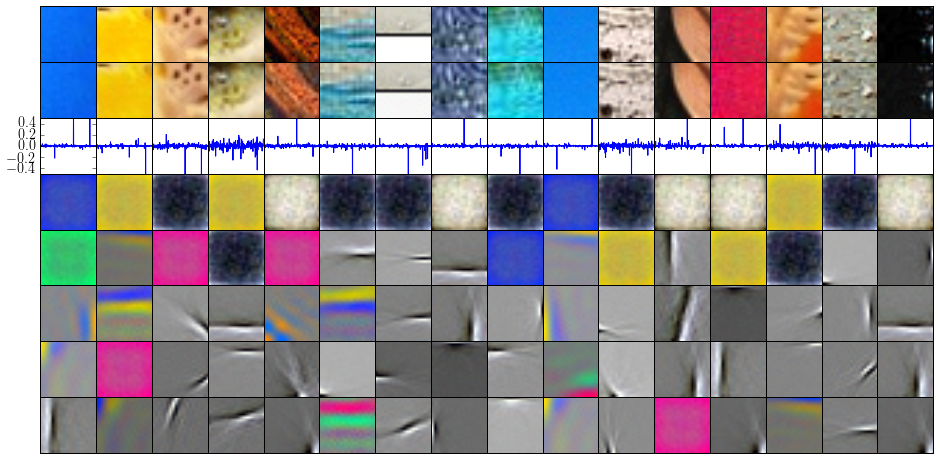

In [456]:
figure(figsize=(16, 8))

ic_ex = 2*arange(5)+1
nrows = 3 + len(ic_ex)
for imx in range(nrecon):
    
    ax = subplot(nrows, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(nrows, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(nrows, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

          
    idx_max = np.argsort(abs(ic_code[imx,:]))
  
    for ici,icx in enumerate(ic_ex):
        ax = subplot(nrows, nrecon, imx + 1 + (3+ici)*nrecon)
        ic_compr = ic_comp[idx_max[-icx],:].reshape(patch_size[0], patch_size[1], 3) 
        ic_compr = ic_compr * ic_code[imx, idx_max[-icx]] # this just flips it if its negative
        imshow(norm_range(ic_compr))
        ax.set_xticks([])
        ax.set_yticks([])
    


In [457]:
def draw_ic_im(ic_coef, ic_comps, nx, ny, patch_size):
    im = np.zeros((int(ny*patch_size[1]), int(nx*patch_size[0]), 3))
    
    cfx = 0
    for ix in range(nx):
        for iy in range(ny):
            ic_recon = np.dot(ic_coef[cfx], ic_comps)
            ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
            
            ic_reconr = (ic_reconr + mean01)
            
            ic_reconr[ic_reconr<0] = 0 
            ic_reconr[ic_reconr>1] = 1
            
            
            im[iy*patch_size[1]:(iy+1)*patch_size[1], 
                      ix*patch_size[0]:(ix+1)*patch_size[0], :] = ic_reconr #norm_range(ic_reconr)
            cfx+=1
            
    return im


## FHRR images

In [458]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b, pa=1, pb=1):
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)    
    
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    
    if not pa==1:
        a = fhrr_pow(a, pa)
        
    if not pb==1:
        b = fhrr_pow(b, pb)
  
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
              
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
 
    
def fhrr_pow(a, pa=1):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    
    if not pa == 1:
        ma = (ra**2 + ia**2) ** (pa/2) 
        aa = pa * (np.arctan(ia/ra) + (ra < 0) * np.pi)
        ra = ma * np.cos(aa)
        ia = ma * np.sin(aa)
        
    c = np.zeros_like(a)
    c[:, :N2] = ra
    c[:, N2:] = ia
    
    return c
    
def fhrr_roll(a, r=1):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

def fhrr_cc(a, b):
    
    pass
    

In [459]:
def sparsify(x, tau=1):
    return 0.5*tau*(np.exp(x/tau) - np.exp(-x/tau))

# Multiple Unbinding


In [460]:
N = 5000

objD = 120
trfD = 60

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1
#obj_vecs = obj_vecs / N**0.5
#trf_vecs = trf_vecs / N**0.5

# This sets the coefficients of the two bound vectors
b_objc = np.zeros(objD)
b_trfc = np.zeros(trfD)

# We'll turn two vectors on by giving them coefficients of 1
b_objc[10] = 1
#b_objc[20] = 0.7

b_trfc[14] = 1
#b_trfc[18] = 1

bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs)

# By resonance, I mean positive feedback by having the eigenvectors grow and then be renormalized
# having the eigenvalues as 1 is good enough though (any positive value really e.g. it is 0 vs. 1)
eignorm = 1
obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)

# So instead of setting the initial vectors to be the sum of all potential,
# we can just set it randomly
obj_state = np.random.randn(N)
trf_state = np.random.randn(N)
#trf_state = trf_vecs.sum(axis=0)
#let_state = let_vecs.sum(axis=0)

obj_state = obj_state / np.linalg.norm(obj_state)
trf_state = trf_state / np.linalg.norm(trf_state)


n_steps = 10

obj_coef_hist = np.zeros((n_steps, objD))
trf_coef_hist = np.zeros((n_steps, trfD))

thal_vec = np.zeros_like(bound_vec)

for i in range(n_steps):
    thal_vec[:] = bound_vec
    
    obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state) / N**0.5
    trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state) / N**0.5
    
    thal_vec -= trf_state * obj_state *N
    
    obj_state = np.dot(obj_resonance, trf_state * thal_vec + obj_state)
    #obj_state = obj_state / np.linalg.norm(obj_state)

    trf_state = np.dot(trf_resonance, obj_state * thal_vec + trf_state) 
    #trf_state = trf_state / np.linalg.norm(trf_state)

    

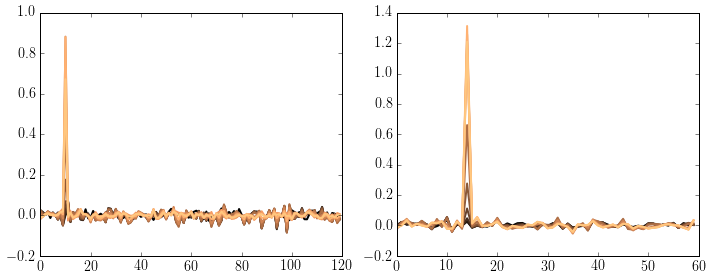

In [461]:
cols = get_cmap('copper', n_steps)

figure(figsize=(10,4))

for i in range(n_steps):
    subplot(121)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    subplot(122)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)

plt.tight_layout()

## HD Map-Seeking Circuit



In [644]:
N=5000
icD = len(which_pcs)
ic_hyperpatch = fhrr_vec(icD, N)

nx_patch = 8
ny_patch = 6

loc_hyperbase = fhrr_vec(2, N) #2*(np.random.randn(2, N) < 0) - 1

locD = nx_patch * ny_patch
loc_vecs = np.zeros((locD, N))
c=0
code_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        
        code_v = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[1],:], pa=(ix+1), pb=(iy+1))
        loc_vecs[c, :] = code_v
        c+=1
        
        #code_v = fhrr_bind(fhrr_roll(loc_hyperbase[[0],:], ix+1), 
        #                   fhrr_roll(loc_hyperbase[[1],:], iy+1))
        ic_code = fhrr_bind(np.tile(code_v, (icD, 1)), ic_hyperpatch)
        
        
        code_vecs.append(ic_code)
        

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


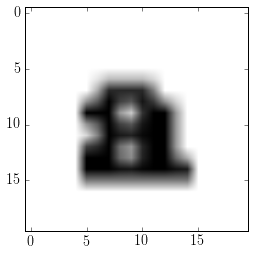

In [645]:
from PIL import ImageFont
from scipy.misc import imresize

font = ImageFont.load_default().font

#font = ImageFont.truetype('Arial', size=15)

letters = 'abcdefghijklmnopqrstuvwxyz'

font_ims = []
fim_size = (patch_size[0],patch_size[1],3)

for l in letters:

    imtext = np.array(font.getmask(l))
    imsize = font.getsize(l)

    imtext = np.tile(imtext.reshape((imsize[1], imsize[0], 1)), (1,1,3))
    imtext = imresize(imtext, 1.8)
    #print imtext.shape
    imtext = imtext[:patch_size[0], :patch_size[1], :]
    #print imtext.shape
    
    imsize = imtext.shape
    
    fim = np.zeros(fim_size)
    
    fimr = np.floor((fim_size[0] - imsize[0])/2)
    fimc = np.floor((fim_size[1] - imsize[1])/2)
    
    fim[fimr:(fimr+imsize[0]), fimc:(fimc+imsize[1]), :] = imtext/255
    
    font_ims.append(1-fim)
    
    #imtext = imtext.reshape((imsize[1], imsize[0]))
    #imshow(imtext)
    
imshow(font_ims[0])

In [932]:
def svd_whiten(X):

    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    X_white = np.dot(U, Vt)

    return X_white

In [756]:
reload(imut)
impatch = imut.load_random_imnet_patches(1, (30,30))


0


In [648]:
np.squeeze(impatch).shape

(30, 30, 3)

figures/fontvec_image-lower-l=a-N=5000-n170131.png
figures/fontvec_image-lower-l=b-N=5000-n170131.png
figures/fontvec_image-lower-l=c-N=5000-n170131.png
figures/fontvec_image-lower-l=d-N=5000-n170131.png
figures/fontvec_image-lower-l=e-N=5000-n170131.png
figures/fontvec_image-lower-l=f-N=5000-n170131.png
figures/fontvec_image-lower-l=g-N=5000-n170131.png
figures/fontvec_image-lower-l=h-N=5000-n170131.png
figures/fontvec_image-lower-l=i-N=5000-n170131.png
figures/fontvec_image-lower-l=j-N=5000-n170131.png
figures/fontvec_image-lower-l=k-N=5000-n170131.png
figures/fontvec_image-lower-l=l-N=5000-n170131.png
figures/fontvec_image-lower-l=m-N=5000-n170131.png
figures/fontvec_image-lower-l=n-N=5000-n170131.png
figures/fontvec_image-lower-l=o-N=5000-n170131.png
figures/fontvec_image-lower-l=p-N=5000-n170131.png
figures/fontvec_image-lower-l=q-N=5000-n170131.png
figures/fontvec_image-lower-l=r-N=5000-n170131.png
figures/fontvec_image-lower-l=s-N=5000-n170131.png
figures/fontvec_image-lower-l=t

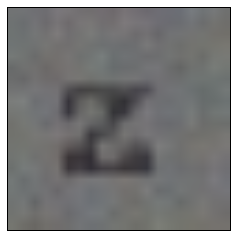

In [666]:
for l in range(fontvecs.shape[0]):
    ic_code = np.dot(ic_hyperpatch, fontvecs[l,:])/N

    imshow(draw_ic_im([ic_code], ic_comp, 1,1,patch_size))
    
    yticks([])
    xticks([])
    
    fname = ('figures/fontvec_image-lower-l=' + letters[l]
             + '-N=' + str(N) +'-n' + time.strftime('%y%m%d') +'.png')
    
    print fname
    savefig(fname, format='png')

In [937]:
fontvecs = np.zeros((len(font_ims), N))
ic_code = np.zeros((len(font_ims), icD))
for let in range(len(font_ims)):
    imp = font_ims[let]
    impatchr = imp.reshape((-1, 1)).copy()
    impatchr[impatchr>mean01] = mean01
    impatchr -= mean01

    ic_c = linalg.lstsq(ic_comp.T, impatchr)
    ic_code[let, :] = ic_c[0].T
    fontvecs[let, :] = np.dot(ic_code[let,:], ic_hyperpatch)


In [939]:
fdecor = svd_whiten(fontvecs)



In [1062]:
fdec_inv = np.linalg.pinv(fdecor)

In [1065]:
print fdec_inv.shape, fdecor.shape

(5000, 26) (26, 5000)


In [ ]:
fdecor *= np.linalg.norm(fontvecs[0,:])

In [940]:
wmat = np.dot(fdecor, np.linalg.pinv(fontvecs))
winv = np.linalg.pinv(wmat)

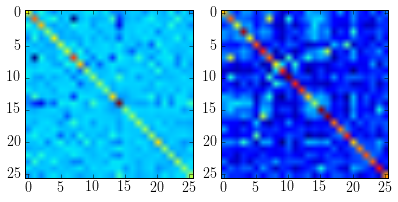

In [941]:
figure(figsize=(7,3))
subplot(121)
imshow(wmat)
subplot(122)
imshow(winv)

figures/decorrelation_image-lower-l=a-N=5000-n170131.png
figures/decorrelation_image-lower-l=b-N=5000-n170131.png
figures/decorrelation_image-lower-l=c-N=5000-n170131.png
figures/decorrelation_image-lower-l=d-N=5000-n170131.png
figures/decorrelation_image-lower-l=e-N=5000-n170131.png
figures/decorrelation_image-lower-l=f-N=5000-n170131.png
figures/decorrelation_image-lower-l=g-N=5000-n170131.png
figures/decorrelation_image-lower-l=h-N=5000-n170131.png
figures/decorrelation_image-lower-l=i-N=5000-n170131.png
figures/decorrelation_image-lower-l=j-N=5000-n170131.png
figures/decorrelation_image-lower-l=k-N=5000-n170131.png
figures/decorrelation_image-lower-l=l-N=5000-n170131.png
figures/decorrelation_image-lower-l=m-N=5000-n170131.png
figures/decorrelation_image-lower-l=n-N=5000-n170131.png
figures/decorrelation_image-lower-l=o-N=5000-n170131.png
figures/decorrelation_image-lower-l=p-N=5000-n170131.png
figures/decorrelation_image-lower-l=q-N=5000-n170131.png
figures/decorrelation_image-low

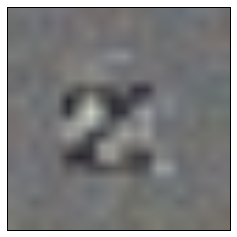

In [888]:
for l in range(fdecor.shape[0]):
    ic_code = np.dot(ic_hyperpatch, fdecor[l,:])/N

    imshow(draw_ic_im([ic_code], ic_comp, 1,1,patch_size))
    
    yticks([])
    xticks([])
    
    fname = ('figures/decorrelation_image-lower-l=' + letters[l]
             + '-N=' + str(N) +'-n' + time.strftime('%y%m%d') +'.png')
    
    print fname
    savefig(fname, format='png')

In [755]:
def make_msc_image(npatch, let=None, pos=None):
    
    if let is None:
        # pick random letter
        let = np.random.randint(len(font_ims))
        
    if pos is None:
        posr = np.random.randint(npatch[0])
        posc = np.random.randint(npatch[1])
    else:
        posr = pos[0]
        posc = pos[1]
        
    pos = (posr, posc)
        
    patch_size= font_ims[0].shape
    
    msc_image = np.ones((font_ims[0].shape[0] * npatch[0], 
                          font_ims[0].shape[1] * npatch[1], 3))
    
    msc_image[posr*patch_size[0]:(posr+1) * patch_size[0],
              posc*patch_size[1]:(posc+1) * patch_size[1], :] = font_ims[let]
    
    msc_image[msc_image > mean01] = mean01
    
    return msc_image, let, pos
    
    

In [1275]:
def make_msc_image_multi(npatch, let=None, pos=None, nsamp=1):
    
    if let is None:
        # pick random letter
        let = np.random.randint(len(font_ims))
        
    if pos is None:
        posr = np.random.randint(npatch[0], size=nsamp)
        posc = np.random.randint(npatch[1], size=nsamp)
    else:
        posr, posc = pos[:,0], pos[:,1]
        
    pos = np.hstack((posr, posc))
        
    patch_size= font_ims[0].shape
    
    msc_image = np.ones((font_ims[0].shape[0] * npatch[0], 
                          font_ims[0].shape[1] * npatch[1], 3))
    
    for i in range(len(posr)):
        msc_image[posr[i]*patch_size[0]:(posr[i]+1) * patch_size[0],
                  posc[i]*patch_size[1]:(posc[i]+1) * patch_size[1], :] = font_ims[let]
    
    msc_image[msc_image > mean01] = mean01
    
    return msc_image, let, pos
    
    

In [1183]:
def make_msc_image_bg(npatch, let=None, pos=None):
    
    if let is None:
        # pick random letter
        let = np.random.randint(len(font_ims))
        
    if pos is None:
        posr = np.random.randint(npatch[0])
        posc = np.random.randint(npatch[1])
    else:
        posr = pos[0]
        posc = pos[1]
        
    pos = (posr, posc)
        
    patch_size= font_ims[0].shape
    
    impatch = imut.load_random_imnet_patches(1, 
                                             (font_ims[0].shape[0] * npatch[0], 
                                              font_ims[0].shape[1] * npatch[1]))
    
    impatch = (np.squeeze(impatch)-1) / 255
    
    
    msc_image = np.ones((font_ims[0].shape[0] * npatch[0], 
                          font_ims[0].shape[1] * npatch[1], 3))
    
    msc_image[posr*patch_size[0]:(posr+1) * patch_size[0],
              posc*patch_size[1]:(posc+1) * patch_size[1], :] = font_ims[let]
    
    msc_image[msc_image > mean01] = impatch[msc_image > mean01]
    
    
    
    return msc_image, let, pos
    
    

figures/input_image-x-34-N=5000-n170202.png


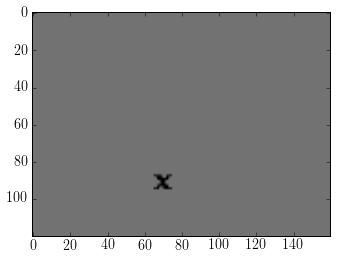

In [1338]:
msc_im, msc_let, msc_pos = make_msc_image((ny_patch, nx_patch), 23)
imshow(msc_im)

fname = ('figures/input_image-' + letters[msc_let] + '-' + str(msc_pos[1]) + str(msc_pos[0])
         + '-N='  + str(N)  + '-n' + time.strftime('%y%m%d') +'.png')
print fname
savefig(fname)

In [1226]:
#msc_im2=msc_im
msc_im3 = (msc_im + msc_im2) / 2


figures/input_image-overlay-j-35-N=5000-n170202.png


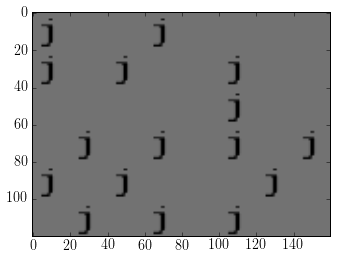

In [1281]:
msc_im, msc_let, msc_pos = make_msc_image_multi((ny_patch, nx_patch), 14, nsamp=1)
imshow(msc_im)

fname = ('figures/input_image-overlay-' + letters[msc_let] + '-' + str(msc_pos[1]) + str(msc_pos[0])
         + '-N='  + str(N)  + '-n' + time.strftime('%y%m%d') +'.png')
print fname

savefig(fname)

In [1228]:
msc_im =msc_im3

 0 figures/input_image-p-31-N=5000-n170201.png


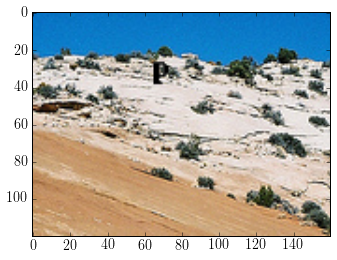

In [1207]:
msc_im, msc_let, msc_pos = make_msc_image_bg((ny_patch, nx_patch), 15)
imshow(msc_im)

fname = ('figures/input_image-' + letters[msc_let] + '-' + str(msc_pos[1]) + str(msc_pos[0])
         + '-N='  + str(N)  + '-n' + time.strftime('%y%m%d') +'.png')
print fname
savefig(fname)

In [1339]:
#

ic_im_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        imp = msc_im[iy*patch_size[1]:(iy+1)*patch_size[1], 
                      ix*patch_size[0]:(ix+1)*patch_size[0], :]
        impatchr = imp.reshape((-1, 1)).copy()
        #impatchr = (impatchr-1)/255
        #impatchr -= impatchr.mean(axis=1)[:, np.newaxis]
        impatchr -= mean01

        ic_c = linalg.lstsq(ic_comp.T, impatchr)
        ic_code = ic_c[0].T
        ic_im_vecs.append(ic_code)
        

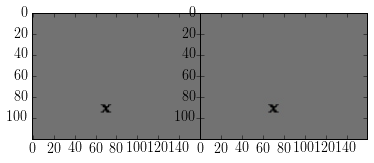

In [1340]:
im_idx = 0

icima = np.array(ic_im_vecs)
subplot(121)
imshow(msc_im)
subplot(122)
imshow(draw_ic_im(icima[:,0,:], ic_comp, nx_patch, ny_patch, patch_size))


figures/letter_correlations-x-34-N=5000-n170202.png


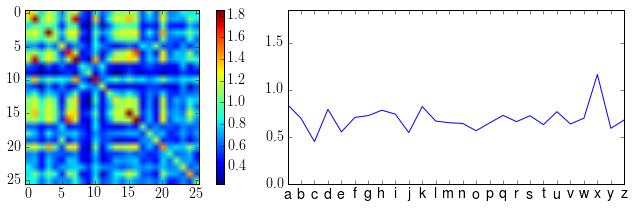

In [1341]:
fvm = fontvecs# - fontvecs.mean(axis=0)

cc = np.dot(fvm, fvm.T)/(2*(N/2)**0.5)
figure(figsize=(10,3))
subplot(121)
imshow(cc)
colorbar()

ax=subplot(122)
plot(cc[msc_let, :])
ax.set_xticks(arange(len(letters)))
ax.set_xticklabels(np.array(list(letters)))
    
ylim([0, cc.max()])
plt.tight_layout()

fname = ('figures/letter_correlations-' + letters[msc_let] + '-' + str(msc_pos[1]) + str(msc_pos[0])
         + '-N='  + str(N)  + '-n' + time.strftime('%y%m%d') +'.png')
print fname
savefig(fname)

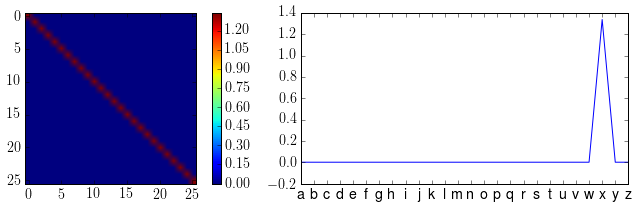

In [1342]:
ccd = np.dot(fdecor, fdecor.T)/(2*(N/2)**0.5)
figure(figsize=(10,3))
subplot(121)
imshow(ccd)
colorbar()

ax=subplot(122)
plot(ccd[msc_let, :])
ax.set_xticks(arange(len(letters)))
ax.set_xticklabels(np.array(list(letters)))
    
plt.tight_layout()

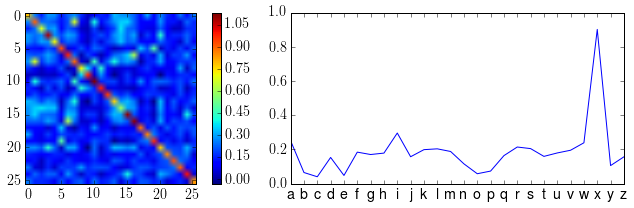

In [1343]:
ccd = np.dot(fontvecs, fdecor.T)/(2*(N/2)**0.5)
figure(figsize=(10,3))
subplot(121)
imshow(ccd)
colorbar()

ax=subplot(122)
plot(ccd[msc_let, :])
ax.set_xticks(arange(len(letters)))
ax.set_xticklabels(np.array(list(letters)))
    
plt.tight_layout()

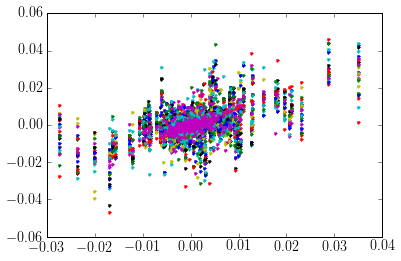

In [1344]:
for l in range(len(font_ims)):
    plot(np.dot(ic_hyperpatch, fontvecs[msc_let,:])/ N, np.dot(ic_hyperpatch, fontvecs[l,:])/ N, '.')

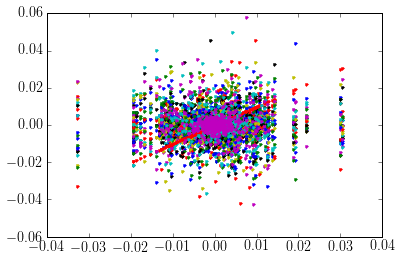

In [1345]:
for l in range(len(font_ims)):
    plot(np.dot(ic_hyperpatch, fdecor[msc_let,:])/ N, np.dot(ic_hyperpatch, fdecor[l,:])/ N, '.')

In [1376]:
max_steps = 1000

cc_states = []
cc_hist = []

nV2 = 1
v2_states_I = []
v2_states_P = []
v2_hist_I = []
v2_hist_P = []

#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(1,N)
    cc_h = np.zeros((max_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
for iV2 in range(nV2):
    v2_si = 0.1*np.random.randn(1,N)
    v2_sp = 0.1*np.random.randn(1,N)
    
    v2_states_I.append(v2_si)
    v2_states_P.append(v2_sp)
    
    v2_hist_I.append(np.zeros((max_steps, len(font_ims))))
    v2_hist_P.append(np.zeros((max_steps, locD)))
    
#bound_imvec = fhrr_bind(fhrr_bind(bound_imvec[np.newaxis], loc_hyperbase[[0],:], pb=0), loc_hyperbase[[1],:], pb=0)
#bound_imvec = icima[:,0,:]
thal_vec = np.zeros((1,N))
fvv = np.zeros((1, N))

for i in range(max_steps):
    thal_vec[:] = bound_imvec
    all_convergedI = np.zeros(nV2)
    all_convergedP = np.zeros(nV2)


    for iV2 in range(nV2):
        v2_hist_I[iV2][[i], :] = np.dot(fontvecs/N, v2_states_I[iV2].T).T
        v2_hist_P[iV2][[i], :] = np.dot(loc_vecs/N, v2_states_P[iV2].T).T
        
        if i > 1:
            all_convergedI[iV2] = np.allclose(v2_hist_I[iV2][i, :], v2_hist_I[iV2][i-1, :])
            all_convergedP[iV2] = np.allclose(v2_hist_P[iV2][i, :], v2_hist_P[iV2][i-1, :])
            
        xIidx = np.argmax(np.abs(v2_hist_I[iV2][i, :]))
        xPidx = np.argmax(np.abs(v2_hist_P[iV2][i, :]))
        
        v2_states_I[iV2] *= np.sign(v2_hist_I[iV2][i, xIidx])
        v2_states_P[iV2] *= np.sign(v2_hist_P[iV2][i, xPidx])
        
        #fvv[:] = 1.0*np.dot(fontvecs.T, np.dot(v2_states_I[iV2], fontvecs.T).T).T / (N/2) **0.5   
        #fvv[:] = v2_states_I[iV2]
        ### Comment out for no explaining away
        #thal_vec -= fhrr_bind(fvv, v2_states_P[iV2])
        ###
        
    if np.all(all_convergedI) and np.all(all_convergedP):
        print 'converged: ', i
        break
    
    for iV2 in range(nV2):
        v2i_upd = np.dot(fdecor, fhrr_bind(fhrr_inv(v2_states_P[iV2]), thal_vec).T)/N
        #v2i_upd = np.dot(fontvecs, fhrr_bind(fhrr_inv(v2_states_P[iV2]), thal_vec).T)/N

        v2p_upd = np.dot(loc_vecs, fhrr_bind(fhrr_inv(v2_states_I[iV2]), thal_vec).T)/N
        
        ### Explaining away:
        #v2_states_I[iV2] = (v2_states_I[iV2] + 0.5*np.dot(v2i_upd.T, fdecor))
        #v2_states_I[iV2] = (v2_states_I[iV2] + 1.1*np.dot(v2i_upd.T, fontvecs))

        #v2_states_P[iV2] = (v2_states_P[iV2] + 0.7*np.dot(v2p_upd.T, loc_vecs))
        ###
        
        ### No explaining away:
        v2_states_I[iV2] = np.dot(v2i_upd.T, fdecor)
        v2_states_P[iV2] = np.dot(v2p_upd.T, loc_vecs)
        v2_states_I[iV2] /= np.linalg.norm(v2_states_I[iV2])
        v2_states_P[iV2] /= np.linalg.norm(v2_states_P[iV2])
        ###
        
n_steps = i

cc_hista = np.array(cc_hist)
let_hista = np.array(v2_hist_I)
loc_hista = np.array(v2_hist_P)


converged:  11


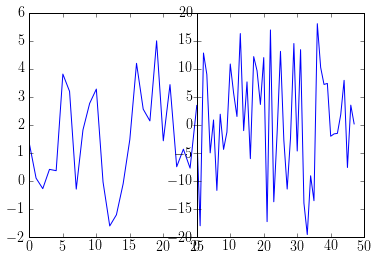

In [1377]:
v2i_upd = np.dot(fontvecs, fhrr_bind(fhrr_inv(np.random.randn(1,N)), bound_imvec).T)
v2p_upd = np.dot(loc_vecs, fhrr_bind(fhrr_inv(np.random.randn(1,N)), bound_imvec).T)

subplot(121)
plot(v2i_upd)
subplot(122)
plot(v2p_upd)

In [1380]:
let_hista = -let_hista
loc_hista = -loc_hista


Letter: "x", Position: 34
figures/hdmsc-msc_im-decor-noexpx-34-nst=11-N=5000-n170202.png


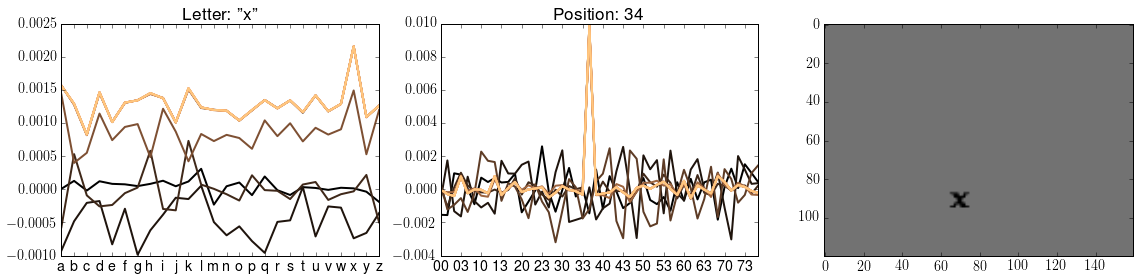

In [1381]:
cols = get_cmap('copper', n_steps)

pos_labels = []
for ix in range(nx_patch):
    for iy in range(ny_patch):
        pos_labels.append(str(ix)+str(iy))
    
pos_x = arange(0, len(pos_labels), 3)

#pos_labels = ['UL', 'UM', 'UR', 'CL', 'CM', 'CR', 'LL', 'LM', 'LR']

figure(figsize=(16,4))

for i in range(n_steps):
    ax1 = subplot(131)
    plot(let_hista[0,i,:], c=cols(i), lw=2)
    ax1.set_xticks(arange(len(letters)))
    ax1.set_xticklabels(np.array(list(letters)))
    title('Letter: "' + letters[np.argmax(np.abs(let_hista[0, n_steps, :]))] +'"')
    
    ax2 = subplot(132)
    plot(loc_hista[0,i,:], c=cols(i), lw=2)
    ax2.set_xticks(pos_x)
    ax2.set_xticklabels(np.array(pos_labels)[pos_x])
    title('Position: ' + pos_labels[np.argmax(np.abs(loc_hista[0,n_steps,:]))])
    
ax3 = subplot(133)
imshow(msc_im)
    
arange(len(pos_labels))
print 'Letter: "' + letters[np.argmax(np.abs(let_hista[0, n_steps, :]))] + '", Position: ' + pos_labels[np.argmax(np.abs(loc_hista[0,n_steps,:]))]


fname = ('figures/hdmsc-msc_im-decor-noexp-' + letters[msc_let] + '-' + str(msc_pos[1]) + str(msc_pos[0])
         + '-nst=' + str(n_steps)
         + '-N='  + str(N)  + '-n' + time.strftime('%y%m%d') + '.png')

plt.tight_layout()

savefig(fname)
print fname

In [1297]:
yl1 = ax1.get_ylim()
yl2 = ax2.get_ylim()

print yl1, yl2


(-0.0050000000000000001, 0.024999999999999998) (-0.050000000000000003, 0.30000000000000004)


0 resanim-hdmsc-test-j-35-nst=999-N=5000-n170202.mp4
0 1 2 3 4 
total time: 1970.34 ms


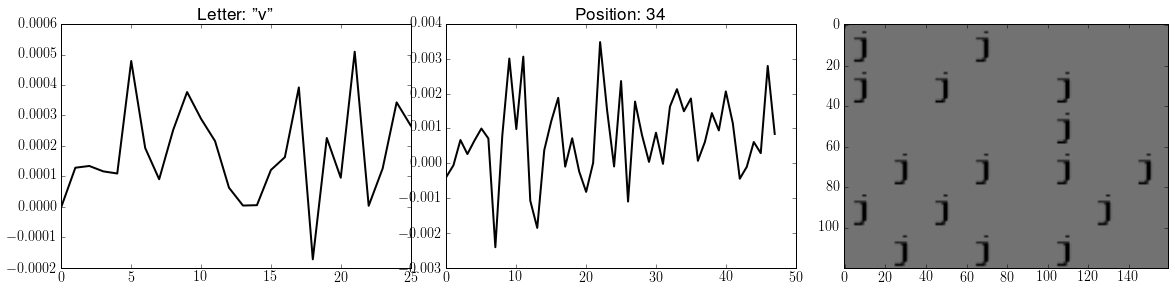

In [1299]:
cols = get_cmap('copper', n_steps)

fh = figure(figsize=(16,4))
ax1 = fh.add_subplot(131)
ax2 = fh.add_subplot(132)
ax3 = fh.add_subplot(133)

ax3.imshow(msc_im)

plt.tight_layout()

def animate(i):
    #tstart =time.time()

    ax1.clear()
    ax2.clear()
    
    #ax3.clear()
    #ax4.clear()
    #ax5.clear()
    #ax6.clear()
    #ax7.clear()
    ax1.plot(let_hista[0,i,:], c=cols(i), lw=2)
    ax1.set_xticks(arange(len(letters)))
    ax1.set_xticklabels(np.array(list(letters)))
    ax1.set_xlim([0, len(letters)])
    ax1.set_title('Letter: "' + letters[np.argmax(np.abs(let_hista[0, i, :]))] +'"')
    ax1.set_ylim(yl1)
    ax1.set_yticks([0])
    
    ax2.plot(loc_hista[0,i,:], c=cols(i), lw=2)
    ax2.set_xticks(pos_x)
    ax2.set_xticklabels(np.array(pos_labels)[pos_x])
    ax2.set_xlim([0, len(pos_labels)])
    ax2.set_title('Position: ' + pos_labels[np.argmax(np.abs(loc_hista[0,i,:]))])
    ax2.set_ylim(yl2)
    ax2.set_yticks([0])
    
    plt.tight_layout()

    print i,

tanim = time.time()
anim = animation.FuncAnimation(fh, animate, frames=n_steps, blit=False)
fname = ('resanim-hdmsc-' + letters[msc_let] + '-' + str(msc_pos[1]) + str(msc_pos[0])
         + '-nst=' + str(n_steps)
         + '-N='  + str(N)  + '-n' + time.strftime('%y%m%d') + '.mp4')
print fname
anim.save(fname, fps=30, extra_args=['-vcodec', 'libx264'])

print ('\ntotal time: %2.2f ms' % (1000*(time.time() - tanim)))


In [624]:
msc_let
letters[msc_let]

'P'

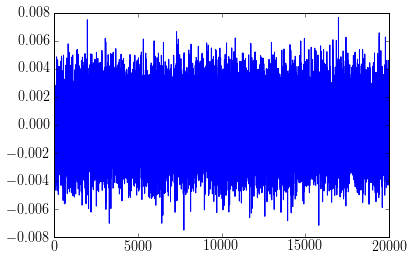

In [276]:
plot(np.dot(np.dot(fontvecs/N, fhrr_bind(fhrr_inv(np.random.randn(1,N)), bound_imvec).T).T, fontvecs).T);

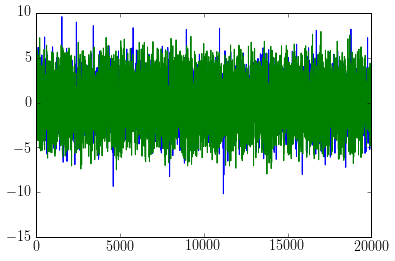

In [264]:
plot(fhrr_bind(np.random.randn(1,N), np.random.randn(1,N)).T);
plot(bound_imvec)

## Texture 



In [74]:
N=20000
icD = len(which_pcs)
ic_hyperpatch = fhrr_vec(icD, N)

nx_patch = 3
ny_patch = 3

loc_hyperbase = fhrr_vec(2, N) #2*(np.random.randn(2, N) < 0) - 1

locD = nx_patch * ny_patch
loc_vecs = np.zeros((locD, N))
c=0
code_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        
        code_v = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[1],:], pa=(ix+1), pb=(iy+1))
        loc_vecs[c, :] = code_v
        c+=1
        
        #code_v = fhrr_bind(fhrr_roll(loc_hyperbase[[0],:], ix+1), 
        #                   fhrr_roll(loc_hyperbase[[1],:], iy+1))
        ic_code = fhrr_bind(np.tile(code_v, (icD, 1)), ic_hyperpatch)
        
        
        code_vecs.append(ic_code)
        

In [141]:
np.array(code_vecs).shape

(25, 240, 100000)

In [24]:
nrecon = 16
big_patch_size = (patch_size[0] * nx_patch, patch_size[1] * ny_patch)

impatch = imut.load_random_imnet_patches(nrecon, big_patch_size)



0


In [25]:
mean01

0.44988148849673171

In [26]:
#

ic_im_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        imp = impatch[ix*patch_size[0]:(ix+1)*patch_size[0], 
                      iy*patch_size[1]:(iy+1)*patch_size[1], :]
        impatchr = imp.reshape((-1, nrecon)).copy()
        impatchr = (impatchr-1)/255
        #impatchr -= impatchr.mean(axis=1)[:, np.newaxis]
        impatchr -= mean01

        ic_c = linalg.lstsq(ic_comp.T, impatchr)
        ic_code = ic_c[0].T
        ic_im_vecs.append(ic_code)
        

In [27]:
impatch.max()

256.0

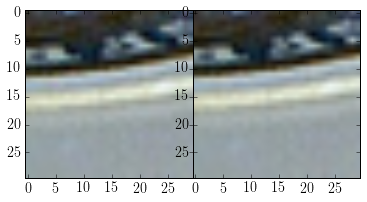

In [75]:
im_idx = 12
icima = np.array(ic_im_vecs)
subplot(121)
imshow(257-impatch[:,:,:,im_idx])
subplot(122)
imshow(draw_ic_im(icima[:,im_idx,:], ic_comp, nx_patch, ny_patch, patch_size))


In [88]:
n_steps = 8

cc_states = []
cc_hist = []

nV2 = 1
v2_states_I = []
v2_states_P = []
v2_hist_I = []
v2_hist_P = []

#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(1,N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
for iV2 in range(nV2):
    v2_si = np.random.randn(1,N)
    v2_sp = np.random.randn(1,N)
    
    v2_states_I.append(v2_si)
    v2_states_P.append(v2_sp)
    
    v2_hist_I.append(np.zeros((n_steps, icD)))
    v2_hist_P.append(np.zeros((n_steps, locD)))
    
bound_imvec = fhrr_bind(fhrr_bind(bound_imvec[np.newaxis], loc_hyperbase[[0],:], pb=0), loc_hyperbase[[1],:], pb=0)
thal_vec = np.zeros((1,N))

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    #thal_vec[:] = fhrr_bind(thal_vec[np.newaxis], loc_hyperbase[[1],:], pb=0)
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][[i],:] = np.dot(code_vecs[iCC]/N, cc_states[iCC].T).T
        
        #thal_vec -= cc_states[iCC]
        
    for iV2 in range(nV2):
        v2_hist_I[iV2][[i], :] = np.dot(ic_hyperpatch/N, v2_states_I[iV2].T).T
        v2_hist_P[iV2][[i], :] = np.dot(loc_vecs/N, v2_states_P[iV2].T).T
        
        thal_vec -= fhrr_bind(v2_states_I[iV2], v2_states_P[iV2])
        
    for iV2 in range(nV2):
        v2i_upd = np.dot(ic_hyperpatch/N, fhrr_bind(fhrr_inv(v2_states_P[iV2]), thal_vec).T)
        v2p_upd = np.dot(loc_vecs/N, fhrr_bind(fhrr_inv(v2_states_I[iV2]), thal_vec).T)
        
        v2_states_I[iV2] += np.dot(v2i_upd.T, ic_hyperpatch)
        v2_states_P[iV2] += np.dot(v2p_upd.T, loc_vecs)
        
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec.T)
        #ncc = np.linalg.norm(cc_upd)
        #cc_upd = sparsify(cc_upd/ncc, 0.1)
        #cc_upd = ncc * cc_upd/np.linalg.norm(cc_upd)
        
        cc_states[iCC] += np.dot(cc_upd.T, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
cc_hista = np.array(cc_hist)

In [48]:
fhrr_bind(v2_states_I[iV2], v2_states_P[iV2]).T.shape

(20000, 1)

In [59]:
thal_vec -= np.squeeze(fhrr_bind(v2_states_I[iV2], v2_states_P[iV2]).T)

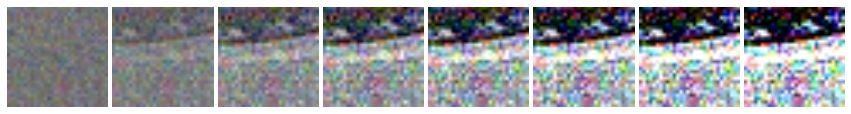

In [89]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow= 8


for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




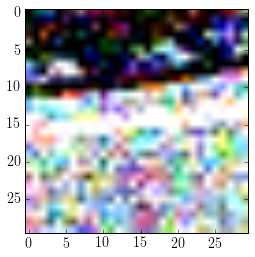

In [90]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))

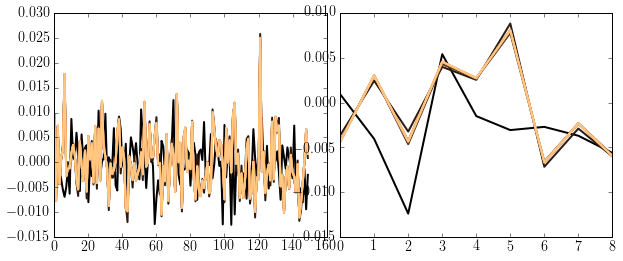

In [91]:
cols = get_cmap('copper', n_steps)

figure(figsize=(10,4))
for i in range(n_steps):
    subplot(121)
    plot(v2_hist_I[0][i,:], c=cols(i), lw=2)
    subplot(122)
    plot(v2_hist_P[0][i,:], c=cols(i), lw=2)


## Sparsification


In [129]:
n_steps = 8

cc_states = []
cc_hist = []
#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
bound_imvec = fhrr_bind(fhrr_bind(bound_imvec[np.newaxis], loc_hyperbase[[0],:], pb=0), loc_hyperbase[[1],:], pb=0)
thal_vec = np.zeros(N)

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    #thal_vec[:] = fhrr_bind(thal_vec[np.newaxis], loc_hyperbase[[1],:], pb=0)
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC]/N, cc_states[iCC]) 
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec)
        ncc = np.linalg.norm(cc_upd)
        cc_upd = sparsify(cc_upd/ncc, 0.1)
        cc_upd = ncc * cc_upd/np.linalg.norm(cc_upd)
        
        cc_states[iCC] += np.dot(cc_upd, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

In [130]:
cc_hista = np.array(cc_hist)

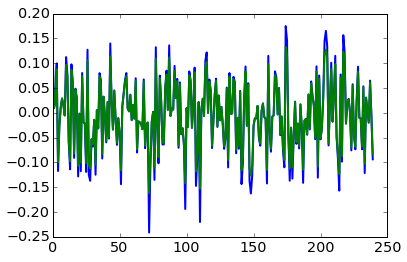

In [131]:
plot(sparsify(cc_upd/ncc, 0.1), lw=2)
plot(cc_upd/ncc, lw=2)


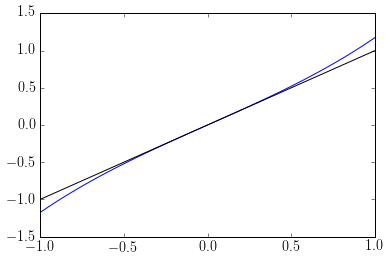

In [152]:
x = linspace(-1, 1,100)
y = sparsify(x, 1)
plot(x,y)
plot(x,x,'k')

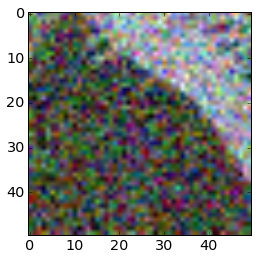

In [106]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))

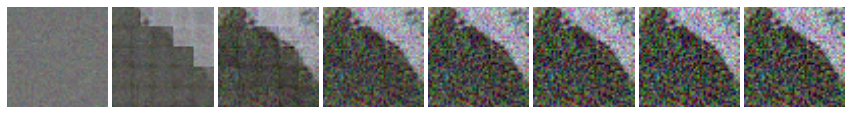

In [138]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




## Translation

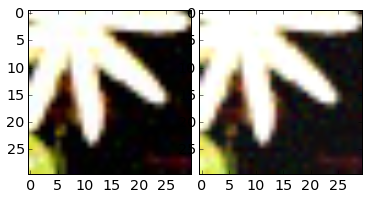

In [66]:
im_idx = 3
icima = np.array(ic_im_vecs)
subplot(121)
imshow(257-impatch[:,:,:,im_idx])
subplot(122)
imshow(draw_ic_im(255*icima[:,im_idx,:], ic_comp, nx_patch, ny_patch, patch_size))


In [281]:
n_steps = 16

cc_states = []
cc_hist = []
#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
thal_vec = np.zeros(N)

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    thal_vec[:] = fhrr_bind(thal_vec[np.newaxis], loc_hyperbase[[1],:], pb=-1)
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC]/N, cc_states[iCC]) 
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec)
        cc_states[iCC] += np.dot(cc_upd, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

In [285]:
cc_hista = np.array(cc_hist)

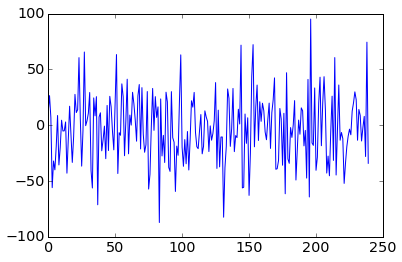

In [97]:
plot(cc_upd*N)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


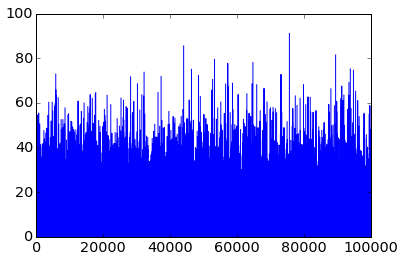

In [74]:
plot(thal_vec**1.5)

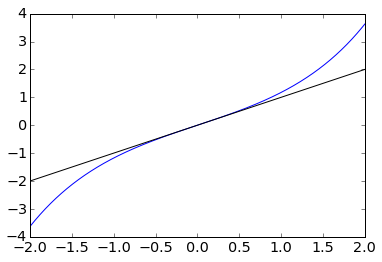

In [94]:
x = np.linspace(-2, 2, 1500)
tau=1
y = 0.5*tau*(np.exp(x/tau) - np.exp(-x/tau))

plot(x,y)
plot(x,x,'k')

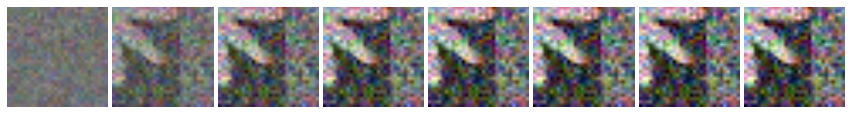

In [289]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




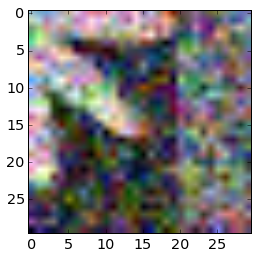

In [290]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))

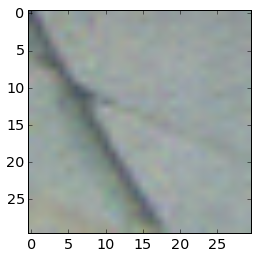

In [67]:
imshow(draw_ic_im(cc_hista[:,i,:]/N, ic_comp, nx_patch, ny_patch, patch_size))

-47.5823955684 37.3377387116
-55.8934254273 22.8238666751
-40.723113386 25.0059925971
-39.8630182901 39.6721118156
-37.2242538313 38.345535738
-47.336182546 34.8831247045
-54.7304532923 -6.0795225052
-58.8654359431 13.9044906167
-41.0941676089 20.5160826302


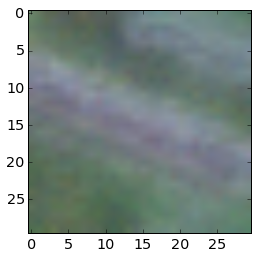

In [45]:
imshow(draw_ic_im(cc_hista[:,i,:]/N, ic_comp, nx_patch, ny_patch, patch_size))

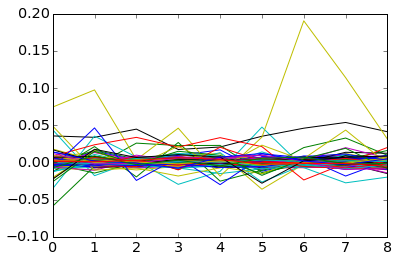

In [37]:
plot(cc_hista[:,1,:]/N/255);

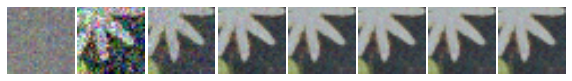

In [62]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(10,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im(255*cc_hista[:, i, :]/N, ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




In [57]:
code_vecs[0].shape

(150, 15000)

In [58]:
cc_hist[0].shape

(10, 150)

In [51]:
n_steps = 10

cc_states = []
cc_hist = []
resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    resonances.append(res)
    
thal_vec = bound_imvec.copy()

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC], cc_states[iCC])
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        
        cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

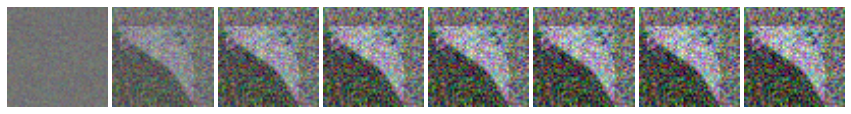

In [71]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow= 8


for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




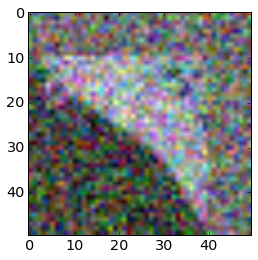

In [72]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))